# Sea Waves Analysis

This notebook analyzes sea wave parameters using multivariate normal distribution. It includes data simulation, statistical testing, and plotting of results.

## Import Libraries

We begin by importing the necessary libraries.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import scipy.stats as scs
import numpy as np
import seaborn as sns

## Define Functions

Next, we define a function to calculate the covariance matrix.


In [2]:
def calvar(x,p):
    mu = np.sum(x*p)
    return np.sum(p*(x-mu)**2)

def calcov(x,y,pxy):
    xy = []
    for xx in x:
        xy = np.append(xy,xx*y)
    xy = xy.reshape(-1,y.shape[0])

    Ex,Ey,Exy = sum(pxy.T@x).round(4),sum(pxy@y).round(4),np.sum(xy*pxy).round(4)
    Cxx,Cyy = calvar(x,np.sum(pxy,axis=1)),calvar(y,np.sum(pxy,axis=0))
    Cxy = Exy-Ex*Ey
    cov = np.array([[Cxx,Cxy],[Cxy,Cyy]])
    mu  = np.array([Ex,Ey])
    return (cov,mu)

## Load and Process Data

We load the data from the CSV file and preprocess it.


In [3]:
df = pd.read_csv('wav_scat.csv', sep=';', index_col=0)

df.index = df.index.values
df.columns = df.columns.values.astype(float)
#df = df.reindex(sorted(df.columns), axis=1)

vhs, vte = df.index.values, df.columns.values.astype(float)
dvt, dvh = np.mean(np.diff(vte)), np.mean(np.diff(-vhs))
pht = df.values

display(df.head())

phs = df.sum(axis=1) / 1e2
pte = df.sum(axis=0) / 1e2

cov,mu = calcov(vte,vhs,pht.T/1e2)

te    = [min(vte), max(vte)]
hs    = [min(vhs), max(vhs)]
nDati = df.shape[0]*df.shape[1]
print('      Mean:', mu)
print('Covariance:', cov)
print('   No.Data:', nDati)

,4.75,5.25,5.75,6.25,6.75,7.25,7.75,8.25,8.75,9.25,9.75,10.25,10.75,11.25,11.75,12.25,12.75,13.25,13.75,14.25
13.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
13.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.01
12.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.00
12.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
11.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.00


      Mean: [8.8278 2.3452]
Covariance: [[2.32329565 0.97194344]
 [0.97194344 1.45546338]]
   No.Data: 560


## Simulate Data

We simulate the data based on the defined parameters and add noise.


In [4]:
rnd_seed = 12321
distr = scs.multivariate_normal(cov=cov, mean=mu, seed=rnd_seed)

nSmpl = 'L'
N = {'L': int(10*nDati), 'S': int(nDati/4)}

nData = N[nSmpl]
fdat = distr.rvs(size=nData)

hsg, teg = np.meshgrid(vhs, vte)
fpdf = distr.pdf(fdat)

t_noi = np.random.normal(0.0, 0.50, nData)
h_noi = np.random.normal(0.0, 0.25, nData)

k = np.where(fdat[:, 0] < min(te))[0]
fdat[k, 0] = min(te)

k = np.where(fdat[:, 1] < min(hs))[0]
fdat[k, 1] = min(hs)

fndat = fdat + np.array([t_noi, h_noi]).T

k = np.where(fndat[:, 0] < min(te))[0]
fndat[k, 0] = min(te)

k = np.where(fndat[:, 1] < min(hs))[0]
fndat[k, 1] = min(hs)

cht = fndat[:, 0] / np.sqrt(fndat[:, 1])

## Perform Hypothesis Test

We perform a one-tailed z-test to test the hypothesis about sea waves.


In [5]:
ctc = 3.87
alf = 1e-2
zsc = scs.norm.ppf(1 - alf)

mcht = np.mean(cht)
scht = np.std(cht)

z = (mcht - ctc) * np.sqrt(nData) / scht

pr = scs.norm.cdf(z)

st, pval = scs.ttest_1samp(cht, ctc, alternative='greater')


#print('Z-Score:', st, ', p-val:', pval)

vLbl = (r'$\mu$:', r'$\sigma$:', r'$n_{SAMPLES}$:', r'$\alpha$:', r'$z_{CRiT}$:', r'$z_{SCORE}$:', r'$p-val$:')
pLbl = ('Mean:', 'St.Dev.:', 'Num.Samp.:', 'Sign.Lvl:', 'Z.Value:', 'Z.Score:', 'p.val')
vVal = (mcht, scht, nData, alf, zsc, z, pval)
vFmt = ('%6.2f', '%6.2f', '%6.0f', '%6.2f', '%6.2f', '%6.2f', '%6.2f')

for i, l in enumerate(pLbl):
    FMT = '%20s' + vFmt[i]
    #print(FMT % (l, vVal[i]))

dc = dict(zip(pLbl, vVal))
dfo = pd.Series(dc).round(4)

dfo.to_csv('Test.csv', sep=';')
display(dfo)

Mean:            6.4652
St.Dev.:         2.3801
Num.Samp.:    5600.0000
Sign.Lvl:        0.0100
Z.Value:         2.3263
Z.Score:        81.5970
p.val            0.0000
dtype: float64

## Plot Results

We generate plots to visualize the results of the analysis.


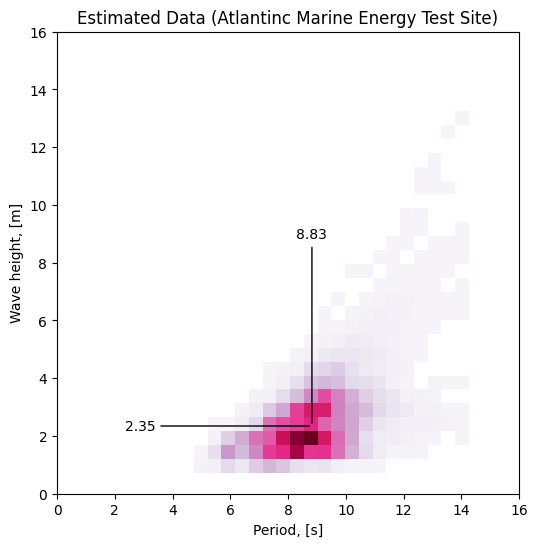

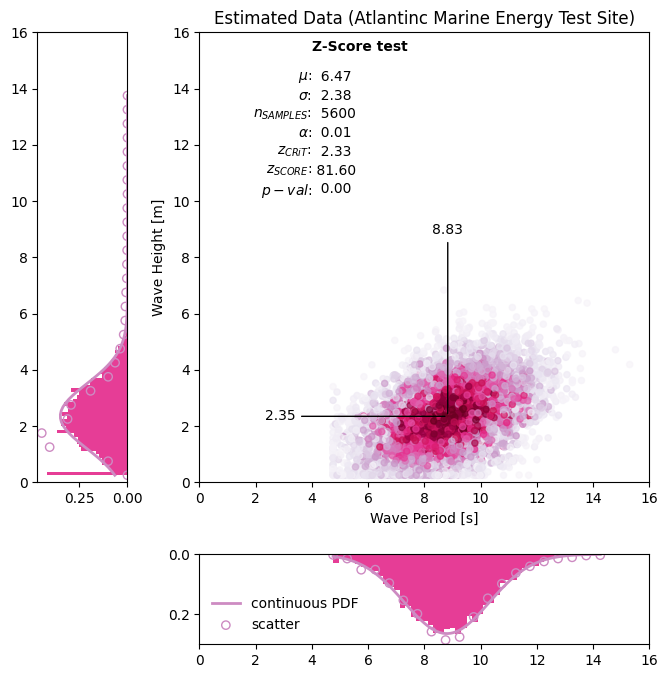

In [12]:
s_title = 'Original Data (Atlantinc Marine Energy Test Site)'
p_title = 'Estimated Data (Atlantinc Marine Energy Test Site)'
LBL = ('Period, [s]','Wave height, [m]')

xMin,xMax = (min(te),max(te))
xMin,xMax = (0,16)
yMin,yMax = (min(hs),max(hs))
yMin,yMax = (0,16)
dx,dy  = (4,2/3)
p_linewidth = 2
p_col= '#0088cc'
p_alpha = 0.7
p_size  = 20

l_col = np.array([4,4,4])/255
p_col = [x/255 for x in [250,140,80]]
l_col = '#1e1e1e'
p_col = '#f0a06e'
cMap  = 'PuRd'

cmap = plt.get_cmap(cMap)
num_colors = 10
hex_col = [mcol.to_hex(cmap(i / num_colors)) for i in range(num_colors)]

p_col = hex_col[4]
l_col = hex_col[-4]

teg,hsg = np.meshgrid(vte,vhs)

fig,ax = plt.subplots(figsize=(6,6))
ax.set_title(p_title)
cax = ax.imshow(df.replace(0,np.nan).values, aspect='auto', cmap=cMap, origin='upper',
                extent=[min(vte), max(vte), min(vhs), max(vhs)])

ax.annotate('%.2f'%mu[0],xytext=(mu[0],mu[0]),xy=(mu[0],mu[1]),ha='center',arrowprops=dict(facecolor='black', arrowstyle='-'))
ax.annotate('%.2f'%mu[1],xytext=(mu[1],mu[1]),xy=(mu[0],mu[1]),va='center',arrowprops=dict(facecolor='black', arrowstyle='-'))

ax.set_xlim(0,16)
ax.set_ylim(0,16)
ax.set_xlabel(LBL[0])
ax.set_ylabel(LBL[1])
ax.set_aspect(1)

fig.savefig('scatter.png',dpi=300)

fig,ax = plt.subplots(1,figsize=(9,9))

ax.set_title(p_title)
cax = ax.scatter(fndat[:,0],fndat[:,1],marker='o',alpha=p_alpha,
           s=p_size,c=fpdf*1e2,cmap=cMap,linewidths=None)
ax.text(xMin+dx,yMax-dy,'Z-Score test',weight='bold')
for i,l in enumerate(vLbl):
    LBL = vFmt[i]%(vVal[i])
    ax.text(xMin+dx,yMax-(i+2)*dy,LBL,va='top',ha='left')
    ax.text(xMin+dx,yMax-(i+2)*dy,l,va='top',ha='right')

ax.annotate('%.2f'%mu[0],xytext=(mu[0],mu[0]),xy=(mu[0],mu[1]),ha='center',arrowprops=dict(facecolor='black', arrowstyle='-'))
ax.annotate('%.2f'%mu[1],xytext=(mu[1],mu[1]),xy=(mu[0],mu[1]),va='center',arrowprops=dict(facecolor='black', arrowstyle='-'))

ax.set_xlim(xMin,xMax)
ax.set_ylim(yMin,yMax)
ax.set_xlabel('Wave Period [s]')
ax.set_ylabel('Wave Height [m]')
ax.set_aspect(1)
#ax.grid()

ax.set_position([.3,.3,.5,.5])
l,b,w,h=ax.get_position().bounds

nd = np.shape(fdat)[1]
pvec = np.array([[l,.12,w,.1],[.12,b,.1,h]])
argMin = (min(te),min(hs))
argMax = (max(te),max(hs))
hor = ['vertical','horizontal']
xd,yd = [vte,vhs],[pte/dvt,phs/dvh]
for i in range(nd):

    axt = fig.add_axes(pvec[i,:])

    y = fdat[:,i]
    xMin,xMax = (argMin[i],argMax[i])
    std = np.std(y)
    mean = np.mean(y)

    x = np.linspace(xMin,xMax,101)
    pdf = scs.norm.pdf(x,mean,std)

    kwargs = dict(histtype='bar',align='mid',color=l_col,rwidth=1, 
                  alpha=.96, density=True, bins=50, orientation=hor[i])

    ns,_,patches = axt.hist(y,**kwargs)

    if hor[i]=='horizontal':
        axt.plot(pdf,x,'-',color=p_col,lw=p_linewidth)
#        ml,sl,bl = axt.stem(xd[i],yd[i],orientation=hor[i])
#        ml.set_markeredgecolor(p_col)
#        ml.set_markerfacecolor('none')
#        sl.set_color(p_col)
#        bl.set_color('none')
        axt.scatter(yd[i],xd[i],c='none', edgecolors=p_col)
        axt.set_ylim(yMin,yMax)
        axt.invert_xaxis()
        #axt.grid(axis='y')
    else:
        axt.plot(x,pdf,'-',color=p_col,lw=p_linewidth,label='continuous PDF')
#        axt.scatter(xd[i],yd[i],c='white',edgecolors=p_col)
        axt.scatter(xd[i],yd[i],c='none', edgecolors=p_col,label='scatter')
        axt.set_xlim(yMin,yMax)
        axt.invert_yaxis()
        #axt.grid(axis='x')
        axt.legend(frameon=False)
    fig.savefig('test-'+nSmpl+'.png',dpi=300)